# Initial imports and constants definition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread # to view images
import os

INPUT_DIR = '../input/airbus-ship-detection/'
TRAIN_DIR = os.path.join(INPUT_DIR, 'train_v2/')
TEST_DIR = os.path.join(INPUT_DIR, 'test_v2/')

print(os.listdir(INPUT_DIR))

['test_v2', 'sample_submission_v2.csv', 'train_ship_segmentations_v2.csv', 'train_v2']


# Utility to encode/decode "run length" encoded labels
[https://www.kaggle.com/paulorzp/run-length-encode-and-decode](http://)

In [2]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Examine train data

In [3]:
masks = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
masks.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


In [5]:
sample_sub = pd.read_csv('../input/airbus-ship-detection/sample_submission_v2.csv')
sample_sub.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [6]:
sample_sub.describe()

,ImageId,EncodedPixels
count,15606,15606
unique,15606,1
top,00002bd58.jpg,1 2
freq,1,15606


# Examine images

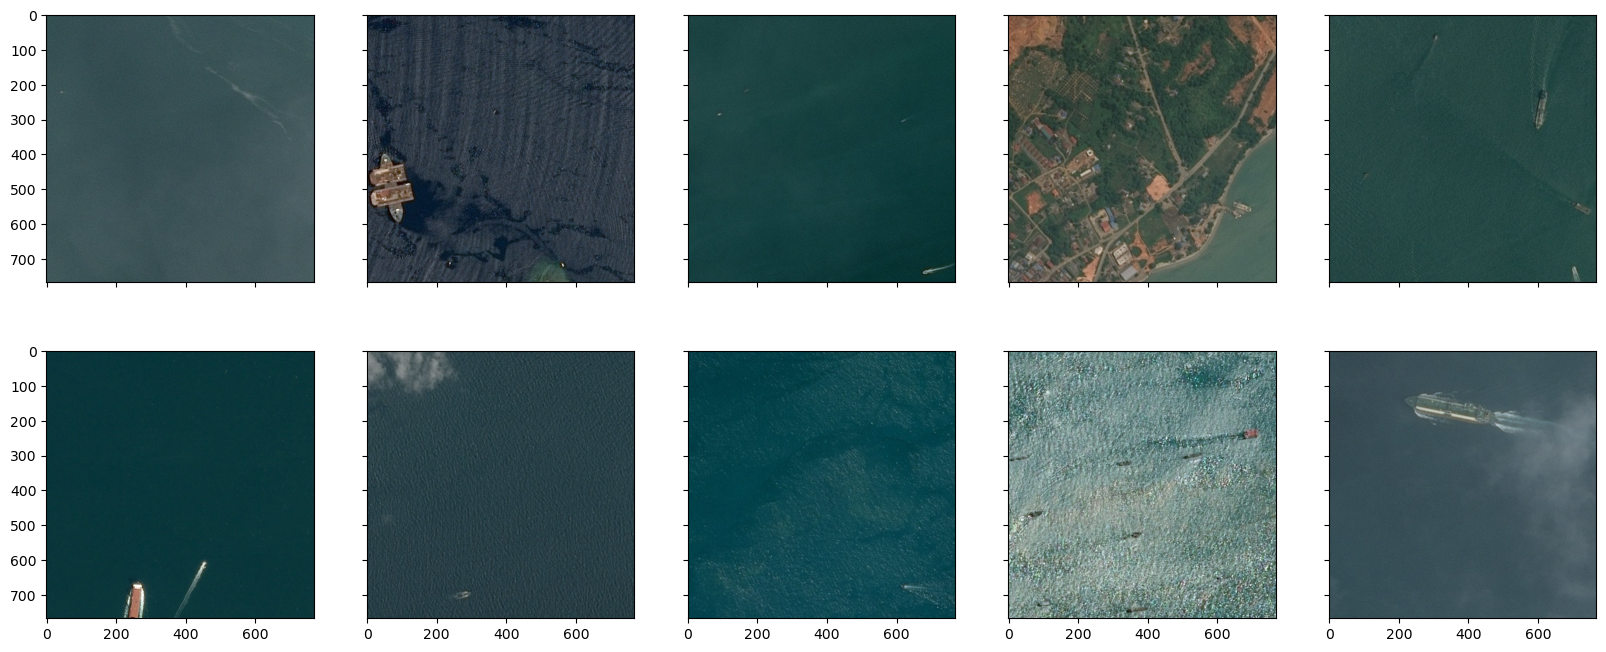

In [7]:
sample_with_ships = masks[~masks.EncodedPixels.isna()].sample(10)

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 8)

for i, image_id in enumerate(sample_with_ships.ImageId):
    image = imread(os.path.join(TRAIN_DIR, image_id))
    ax[i // 5, i % 5].imshow(image)

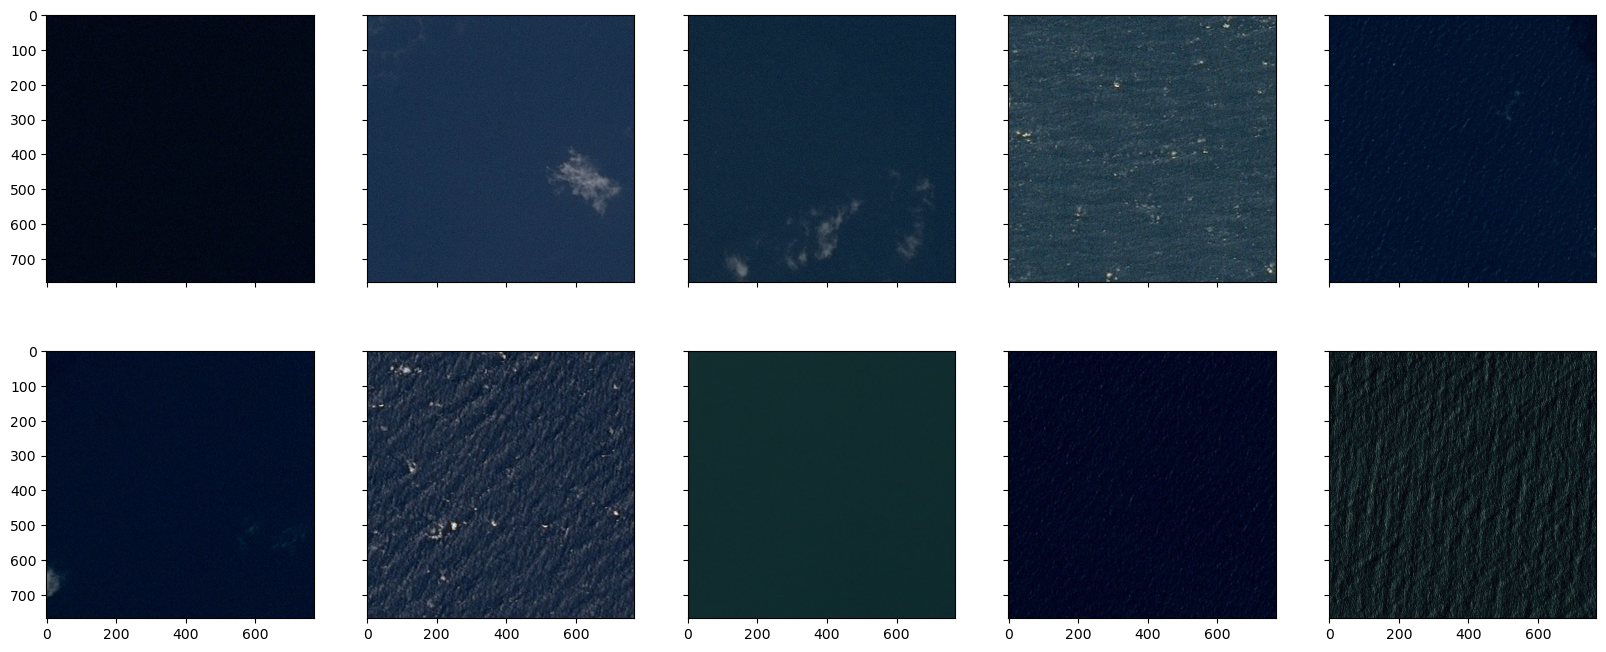

In [8]:
sample_without_ships = masks[masks.EncodedPixels.isna()].sample(10)

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 8)

for i, image_id in enumerate(sample_without_ships.ImageId):
    image = imread(os.path.join(TRAIN_DIR, image_id))
    ax[i // 5, i % 5].imshow(image)

# Compare classes with ships and without

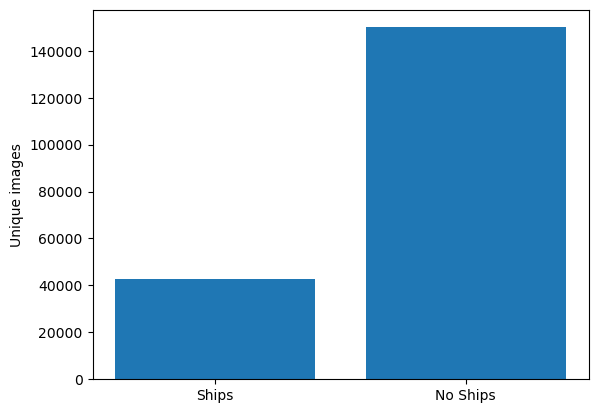

In [9]:
unique_with_ships = masks[~masks.EncodedPixels.isna()].ImageId.unique()
unique_without_ships = masks[masks.EncodedPixels.isna()].ImageId.unique()

plt.bar(['Ships', 'No Ships'], [len(unique_with_ships), len(unique_without_ships)]);
plt.ylabel('Unique images');

# Split into training and validation groups
Stratify by the number of boats for good balance

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
33803,2ceade0b5.jpg,0,0.0,[0.0],221.104492
186550,f81b3da51.jpg,0,0.0,[0.0],175.923828
155754,cf2a1dee2.jpg,0,0.0,[0.0],86.355469
372,0086bf67c.jpg,0,0.0,[0.0],79.257812
55355,49c4c3643.jpg,0,0.0,[0.0],324.882812


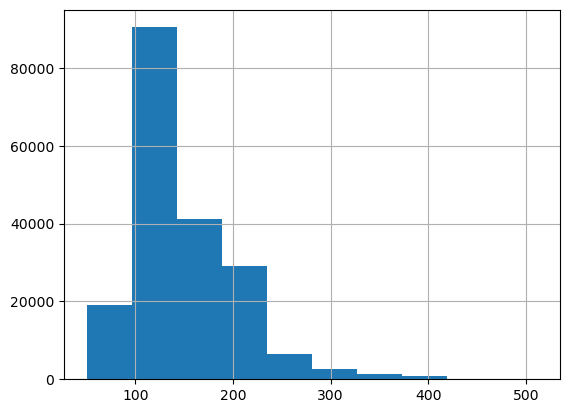

In [10]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(TRAIN_DIR, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

# Examine distribution by groups of different ship numbers

<Axes: >

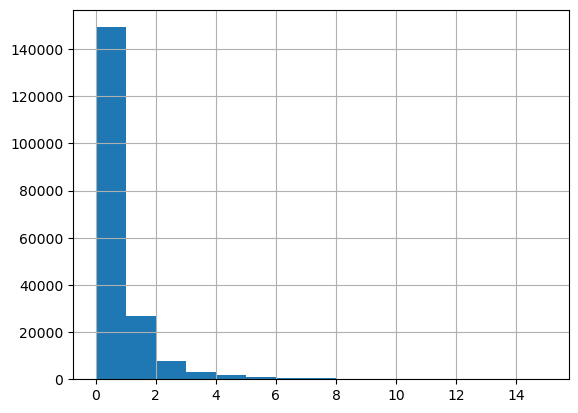

In [11]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

# Undersample images with not many or zero ships

8180 masks


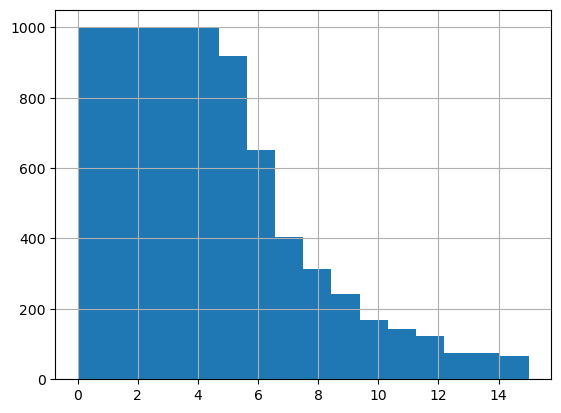

In [12]:
SAMPLES_PER_GROUP = 1000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [13]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

27813 training masks
6957 validation masks
